# Import our in-house package and dependencies
Should install relevant dependencies if there is a conflict

In [128]:
import RoPeR
from RoPeR import bandpass, bgr, energy_eq, gain, prestitch

In [129]:
import os
from tqdm import tqdm
from pds4_tools.reader.core import pds4_read
import numpy as np
import matplotlib.pyplot as plt

# Load the RoPeR data from a folder on our computer which contains the data files

In [228]:
'''
Retrieving files and sorting them
'''
n, m = 0, 109 # 0-109, load all 109 files
data_dir = '/Users/coltenrodriguez/Desktop/Senior_Thesis/RoPeR_LF' # were data

In [229]:
files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if '.2CL' in f]
files = sorted(files, key=lambda f: int(f[-10:-6]))[n:m]
length = len(files)

sample_depth = {6000:15000, 4000:10000, 2000:5000, 1000:2500} # number of total pixels in either R/I data: nanoseconds penetration
observable_depth_ns = 1200 # Arbitaraty value

In [230]:
from collections import Counter, defaultdict
'''
Check inhomogenous data (e.g. not all files are LF). also get the effective data legnth (to get ns/px)
'''

effective_data_lens = [info[8] for info in [pds4_read(file, quiet=True)[0].data[0] for file in files]] # Just take the metadata associated with the first trace, as each trace in each file will be the same


if len(set(effective_data_lens)) == 1:
    print(f"Input data is homogenous. Effective data length is {effective_data_lens[0]} bytes. \n {effective_data_lens[0]/8} fpn for real data -- {(effective_data_lens[0]/8)/sample_depth[effective_data_lens[0]/8]} px/ns")
    half_length = int(effective_data_lens[0]/8)
    px_per_ns = half_length/sample_depth[effective_data_lens[0]/8]
else:
    print("Inhomogenous data types. Check that all files are LF or have the same effective data length")

Input data is homogenous. Effective data length is 48000 bytes. 
 6000.0 fpn for real data -- 0.4 px/ns


In [231]:
remove_air = 0

In [252]:
'''
Stitching multiple data files together and gathering some preprocessing data for each file
'''
phase = [0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
pixel_distances = []
sample_meta = None
for f, i, j in zip(files, range(0, length), tqdm(range(length-1))): 
    if n<=i<=m:
        fdata = pds4_read(f, quiet=True)[0].data
        if len(set([int.from_bytes(d[6], 'big', signed=False) for d in fdata])) > 1:
            raise Exception("Trigger mode is not homogenously fixed_distance")
        distance_fixs.append([int.from_bytes(d[7], 'big', signed=False) for d in fdata])
        sample_meta = fdata[0] # might be useless
        scan2d = np.array([d[9] for d in fdata])
        real_part_scan2d = np.array(scan2d[:, :half_length]).T[remove_air:, :]

        sample_depth_px, real_part_scan2d_depth_adj = prestitch.depth_correction(real_part_scan2d, px_per_ns, observable_depth_ns)
        real_part_scan2d_depth_self_adj = prestitch.remove_self_detection(real_part_scan2d_depth_adj)
        real_part_scan2d_depth_self_phase_adj = prestitch.phase_correction(real_part_scan2d_depth_self_adj, phase[i])
    
        # Assume this is all interpreted
        yaw = np.array([d[23] for d in fdata])
        pos_x = np.array([d[19] for d in fdata])
        pos_y = np.array([d[20] for d in fdata])
        pos_z = np.array([d[21] for d in fdata])
        pixel_distances.append(np.array([int.from_bytes(d[7], 'big', signed=False) for d in fdata])*10e-3)
        if i == n:
            raw = real_part_scan2d_depth_adj
            self_detection = real_part_scan2d_depth_self_adj
            phase_offset = real_part_scan2d_depth_self_phase_adj
            yaws = yaw
            poss_x, poss_y, poss_z = pos_x, pos_y, pos_z
            trace_dist_m = np.sum(np.array([int.from_bytes(d[7], 'big', signed=False) for d in fdata])*10e-3) # Fixed dist trigger is not fixed for all scans, record dist in a way that pulls from the .CL
        else:
            raw = np.concatenate((raw, real_part_scan2d_depth_adj), axis=1)
            self_detection = np.concatenate((self_detection, real_part_scan2d_depth_self_adj), axis=1)
            phase_offset = np.concatenate((phase_offset, real_part_scan2d_depth_self_phase_adj), axis=1)
            yaws = np.concatenate((yaws, yaw))
            poss_x, poss_y, poss_z = np.concatenate((poss_x, pos_x)), np.concatenate((poss_y, pos_y)), np.concatenate((poss_z, pos_z))
            trace_dist_m+=np.sum(np.array([int.from_bytes(d[7], 'big', signed=False) for d in fdata])*10e-3)
            

100%|███████████████████████████████████████████████████████| 107/107 [00:20<00:00,  5.19it/s]


# Load a couple functions that make manipulating the data easier

**meters_to_pixels**: 
    
    takes a range along the horizontal and transforms it into pixel indices. this is useful as the RoPeR fixed distance trigger has multiple fixed distances under which it operates, for LF, this switches from 1 recording every 0.5m to everyu 0.25m

**norm2d**:

    Normalizes a 2d array to 0-1

**zoom**:

    Takes a slice of the full data. Useful for hyperbola tracing in velocity modeling, to check data quality, or to simply zoom in on features of the data



In [396]:
def meters_to_pixels(meter_interval, pixel_distances):
    start_m, end_m = meter_interval

    # cumulative distance to the start of each pixel
    cumulative_m = np.concatenate(([0], np.cumsum(pixel_distances)))

    # find pixel indices
    start_pixel = np.searchsorted(cumulative_m, start_m, side="left")
    end_pixel = np.searchsorted(cumulative_m, end_m, side="right") - 1

    # clamp to valid range
    start_pixel = max(0, min(start_pixel, len(pixel_distances) - 1))
    end_pixel = max(0, min(end_pixel, len(pixel_distances) - 1))

    return start_pixel, end_pixel
    
def norm2d(array):
    min_val = np.min(array)
    max_val = np.max(array)
    
    # Apply the normalization formula
    normalized_array = 2 * ((array - min_val) / (max_val - min_val)) - 1
    
    return normalized_array

def zoom(array, bounds):
    # Bounds in [left, right, bottom, top]
    # [:, :], Col slice (vertical), rows slice (horiz), row slice should be left:right, byut col slice should be bottom:top
    '''
    Bounds should be specified as:

                Left: Left coordinate (in meters)
                Right: Right coord (in meters)
                Top: stratigraphic bottom, the larger twt (in ns)
                Bottom: stratigraphic top, the smaller twt (in ns)

    This way bounds may be passed as an arg to plt without modification to show true (phyiscal) position 
    '''
    left, right = meters_to_pixels((bounds[0], bounds[1]), np.concatenate(pixel_distances).ravel())
    return array[int(bounds[3]*px_per_ns):int(bounds[2]*px_per_ns), left:right], bounds
    

27128466.0 -24998366.0


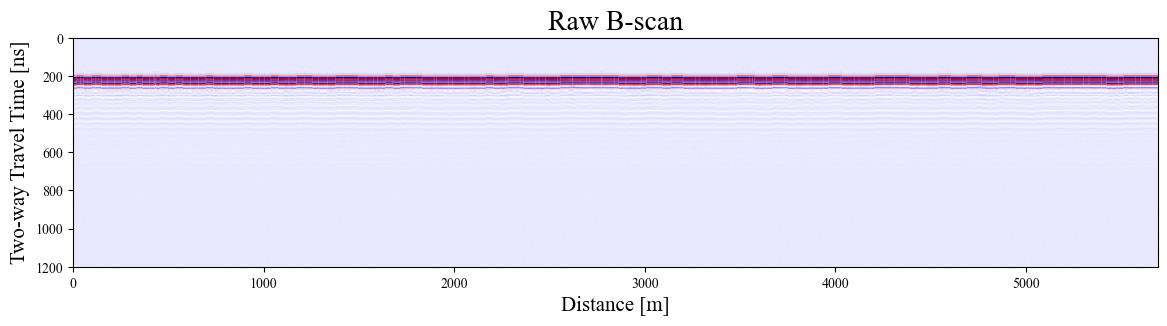

In [397]:
plt.style.use('default')
plt.rcParams.update({
    'font.family': 'serif',  # Often a default in MATLAB
    'font.serif': ['Times New Roman'],
    'axes.labelsize': 15,
    'axes.titlesize': 20,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'lines.linewidth': 1.5,
    'lines.marker': 'o',  # Example marker, adjust as needed
    'grid.color': 'lightgray',
    'grid.linestyle': ':',
    'grid.linewidth': 0.5,
    'axes.grid': False,
    'figure.subplot.wspace': 0,  # Example: Increase horizontal spacing
    'figure.subplot.hspace': 0.4,  # Example: Increase vertical spacing
    'figure.figsize': (14, 4) # Adjust figure size
})
rows, cols = raw.shape
plt.imshow(raw, cmap='seismic', extent = [0, cols, observable_depth_ns, 0])
plt.title("Raw B-scan")
plt.xlabel("Distance [m]")
plt.ylabel("Two-way Travel Time [ns]")
print(np.amax(raw), np.amin(raw))
# 3.5e7 to 7.5e7

Text(0, 0.5, 'Two-way Travel Time [ns]')

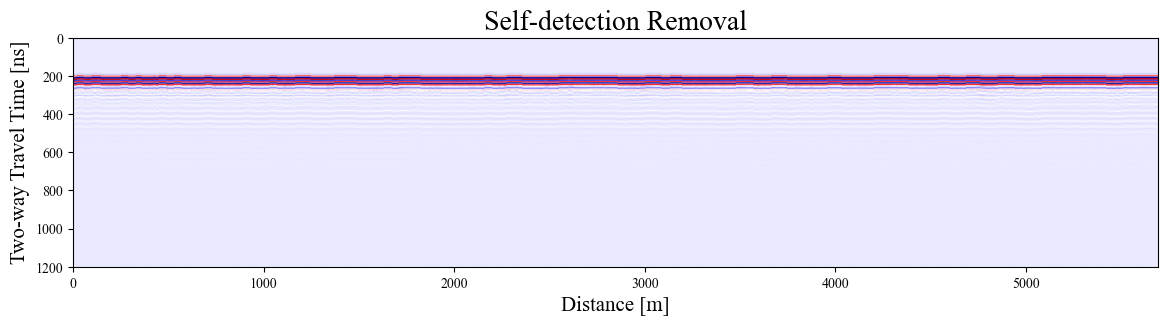

In [398]:
# self_detection = gain.apply_gain(self_detection, param=0.015, gain_type='exponential')
plt.imshow(self_detection, cmap='seismic',extent = [0, cols, observable_depth_ns, 0])
plt.title("Self-detection Removal")
plt.xlabel("Distance [m]")
plt.ylabel("Two-way Travel Time [ns]")

27128466.0 -24998366.0


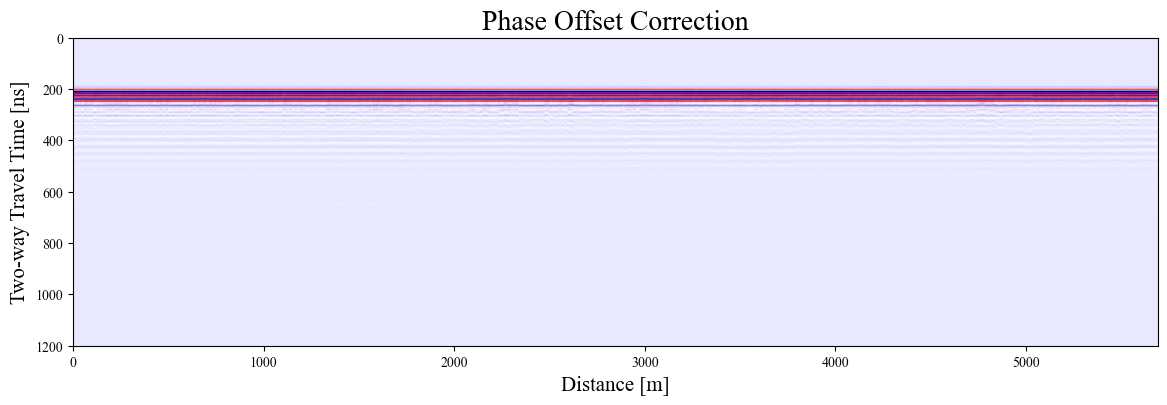

In [399]:
plt.imshow(norm2d(phase_offset), cmap='seismic', aspect='auto', extent = [0, cols, observable_depth_ns, 0])
plt.title("Phase Offset Correction")
plt.xlabel("Distance [m]")
plt.ylabel("Two-way Travel Time [ns]")
print(np.amax(phase_offset), np.amin(phase_offset))

# Remove Horizontal Band and Ringing

2817881.43359375 -2621488.445


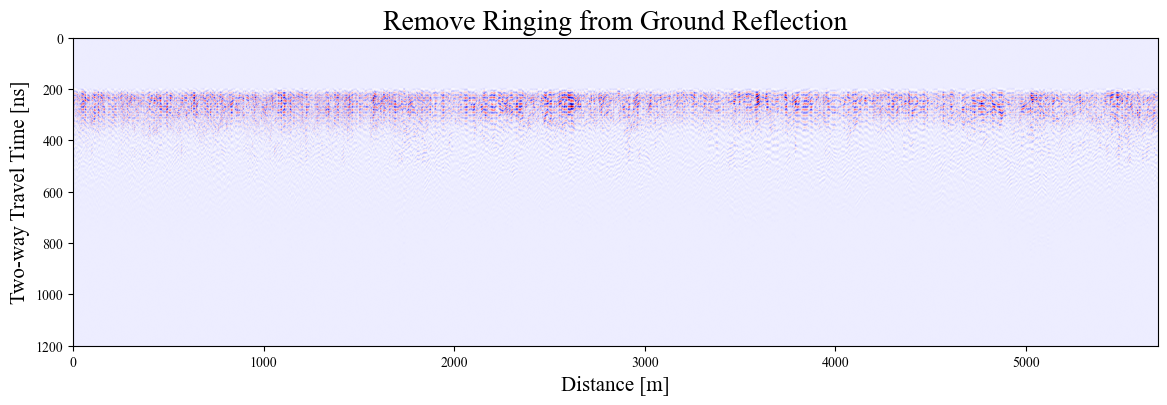

In [400]:
arr, shape = bgr.remove_bg(phase_offset)
arr, shape = bgr.subtract_window_mean(arr, 50)
plt.imshow(norm2d(arr), cmap='seismic', aspect='auto', extent = [0, cols, observable_depth_ns, 0])
plt.title("Remove Ringing from Ground Reflection")
plt.xlabel("Distance [m]")
plt.ylabel("Two-way Travel Time [ns]")
print(np.amax(arr), np.amin(arr))

# Remove duplicate traces

/Users/coltenrodriguez/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/coltenrodriguez/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Text(0, 0.5, 'Two-way Travel Time [ns]')

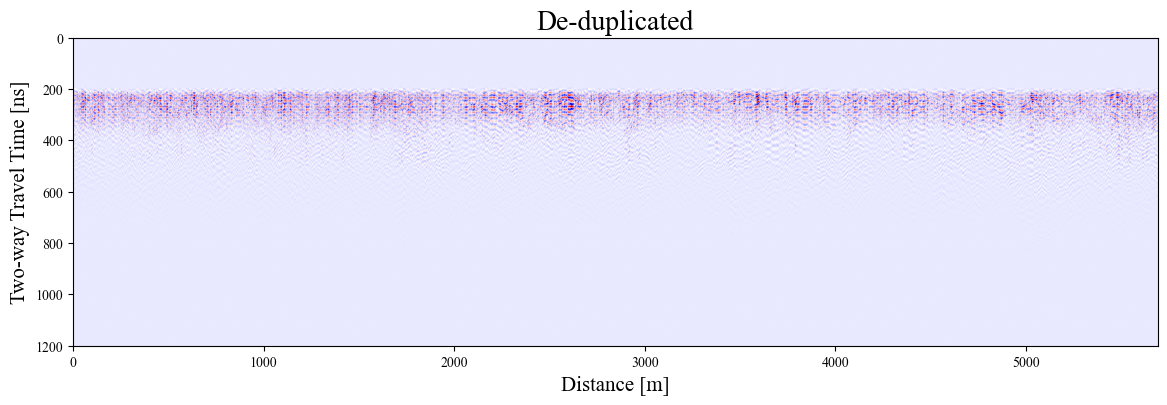

In [401]:
arr, duplicates, anom = bgr.dedupe(arr, arr.shape)
plt.imshow(norm2d(arr), cmap='seismic', aspect='auto', extent = [0, cols, observable_depth_ns, 0])
plt.title("De-duplicated")
plt.xlabel("Distance [m]")
plt.ylabel("Two-way Travel Time [ns]")

# Lateral Energy Equalization

Text(0, 0.5, 'Two-way Travel Time [ns]')

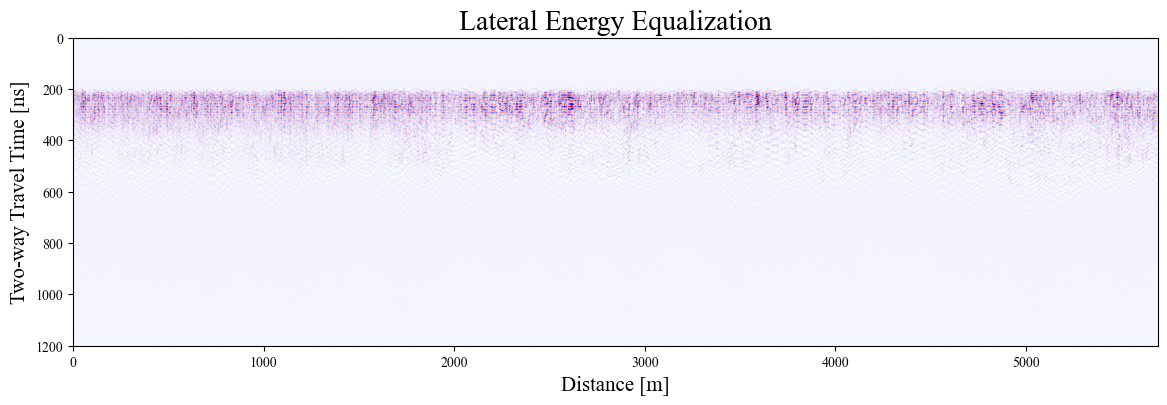

In [402]:
arr = energy_eq.lateral_energy_equalization(arr, 5)
plt.imshow(norm2d(arr), cmap='seismic', aspect='auto', extent = [0, cols, observable_depth_ns, 0])
plt.title("Lateral Energy Equalization")
plt.xlabel("Distance [m]")
plt.ylabel("Two-way Travel Time [ns]")

# Apply Gain

12014373.330450034 -11009224.257169709


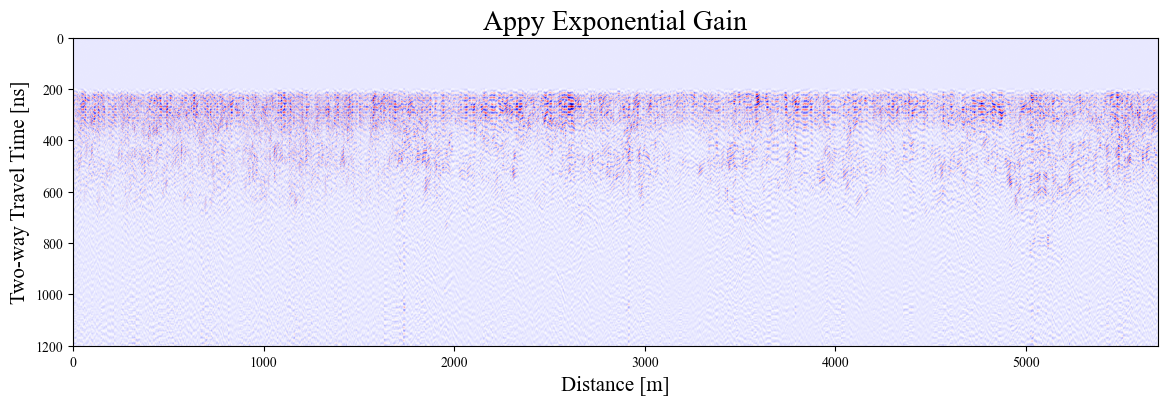

In [403]:
p = gain.apply_gain(arr, 0.014, gain_type='exponential', agc_window=90)
plt.imshow(norm2d(p), cmap='seismic', aspect='auto', extent = [0, cols, observable_depth_ns, 0])
plt.title("Appy Exponential Gain")
plt.xlabel("Distance [m]")
plt.ylabel("Two-way Travel Time [ns]")
print(np.amax(p), np.amin(p))

In [404]:
upper_visible = 200
lower_visible = 800

Text(0, 0.5, 'Two-way Travel Time [ns]')

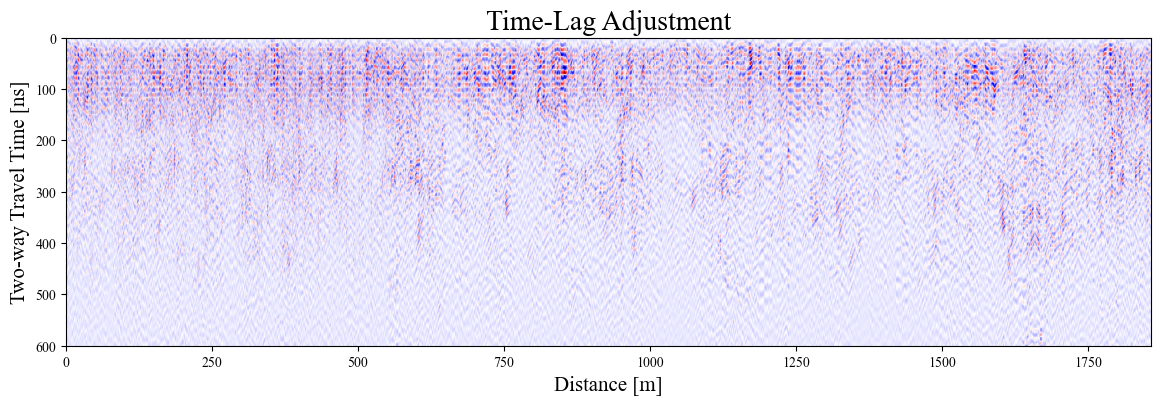

In [405]:
a = p[int(upper_visible*px_per_ns):int(lower_visible*px_per_ns), :]
plt.imshow(norm2d(a), cmap='seismic', aspect='auto', extent = [0, trace_dist_m, lower_visible-upper_visible, 0])
plt.title("Time-Lag Adjustment")
plt.xlabel("Distance [m]")
plt.ylabel("Two-way Travel Time [ns]")

# Neatly align and plot all the data, a "sanity check" figure of the processing done so far

[   0.     309.625  619.25   928.875 1238.5   1548.125 1857.75 ]


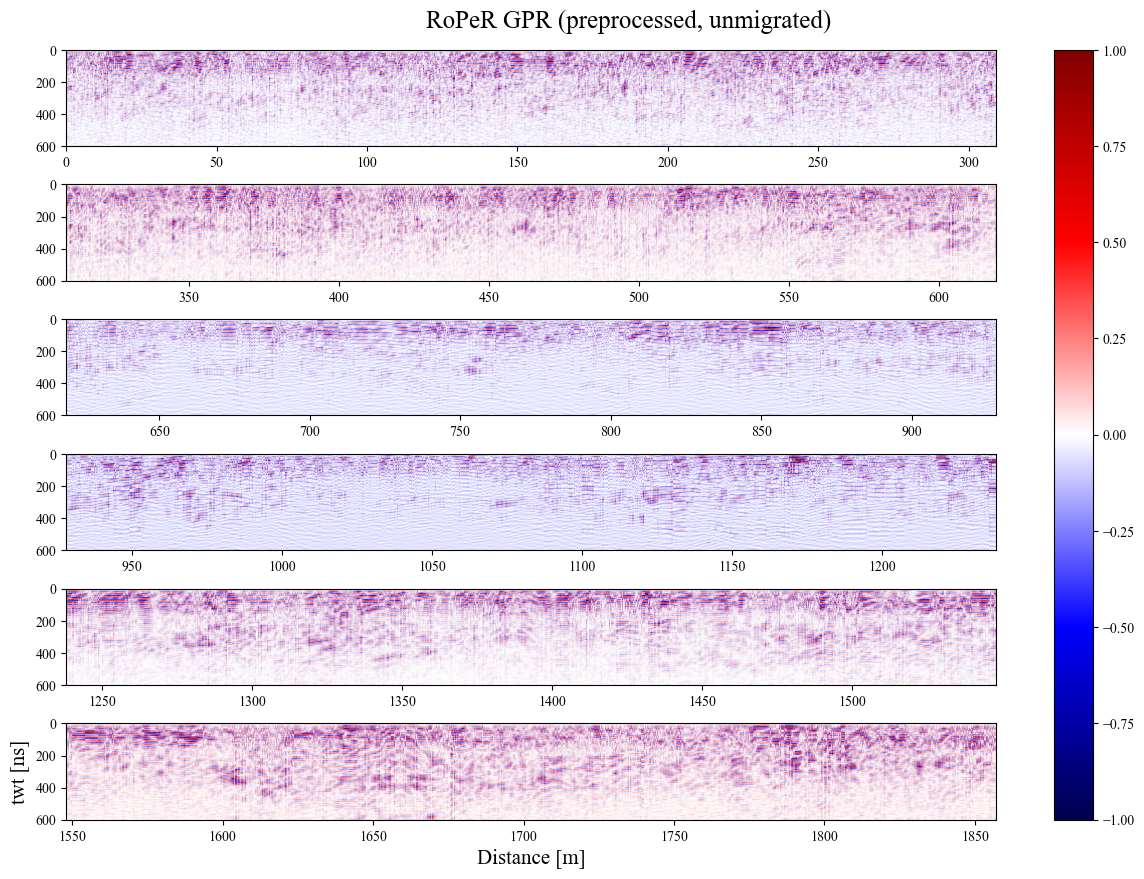

In [408]:
arr = a
n_plots = 6
fig, ax = plt.subplots(n_plots, 1, figsize=(15,10))
step = int(arr.shape[1]/n_plots)
scans = [arr[:, n*step:(n+1)*step] for n in range(0,n_plots)]
trace_dist_iterator = np.array([0, 1, 2, 3, 4, 5, 6])*trace_dist_m/n_plots
print(trace_dist_iterator)

def norm2d(array):
    min_val = np.min(array)
    max_val = np.max(array)
    
    # Apply the normalization formula
    normalized_array = 2 * ((array - min_val) / (max_val - min_val)) - 1
    
    return normalized_array

for i in range(0,len(scans)):
    scan = scans[i]
    d = int(trace_dist_iterator[i+1])-int(trace_dist_iterator[i])
    observable_depth = lower_visible-upper_visible
    plot = ax[i].imshow(norm2d(scan), extent=[int(trace_dist_iterator[i]), int(trace_dist_iterator[i+1]), observable_depth, 0], aspect='auto', origin='upper', cmap='seismic')
    if i == len(scans)-1:
        cbar = fig.colorbar(plot, ax=ax.ravel().tolist(), orientation='vertical')
        ax[i].set_xlabel("Distance [m]")
        ax[i].set_ylabel("twt [ns]")
    fig.suptitle("RoPeR GPR (preprocessed, unmigrated)", fontsize=18, y=0.92)
    

# Generate a velocity model for the subsurface

Li et. al. go to 1200ns. I personally have a hard time trusting data at 171m. Even for dry sand and gravel at such low frequency, everyone I've talked to wouldn't expect >100m. Even the IDed reflectors weren't bellow 20m. I think we strike a good balance restricting ourselves to the upper 80m, which, for the absolute lowest eps_r, should be around 800-1000ns.

(80, 200)


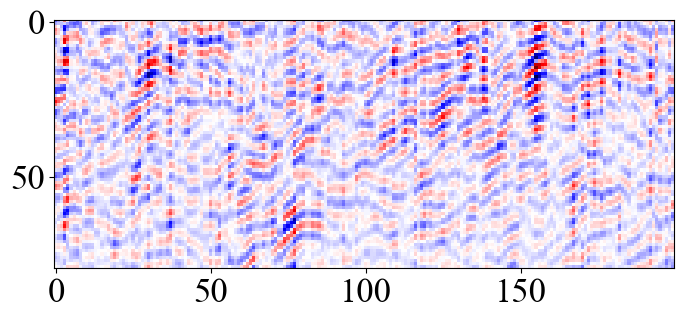

In [588]:
array, bounds = zoom(p, [200, 300, 600, 400])
# fig = plt.figure(figsize=(8,8))
print(array.shape)
plt.imshow(array, cmap="seismic")
# extent = bounds

# hyperbola fitting
1. Draw hyperbola
2. Get overlapping pixel coordinates
3. Convert zoomed coords to physical coords
4. Then back-calculate the eps_r values

In [589]:
import SimulatingGPR.gprsim as gprsim

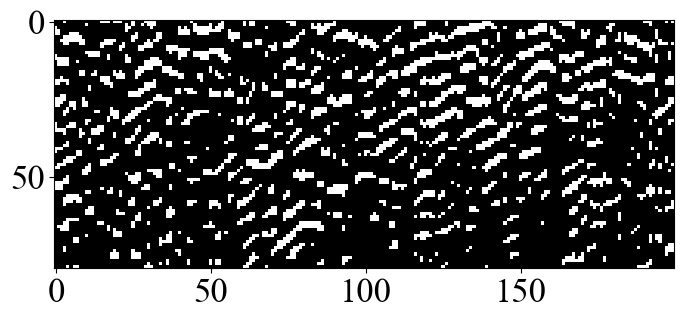

In [591]:
data=array
threshold = np.mean(data[np.where(data>data.max()*0.01)])
data_binary = np.ones_like(data)
data_binary[np.where(data>threshold)] = 0
plt.rcParams.update({
    'font.family': 'serif',  # Often a default in MATLAB
    'font.serif': ['Times New Roman'],
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 25,
    'ytick.labelsize': 25,
    'lines.linewidth': 1.5,
    'lines.marker': 'o',  # Example marker, adjust as needed
    'grid.color': 'lightgray',
    'grid.linestyle': ':',
    'grid.linewidth': 0.5,
    'axes.grid': False,
    'figure.figsize': (8, 6) # Adjust figure size
})
fig = plt.figure(figsize=(8,8))
plt.imshow(data_binary, cmap='binary')

In [592]:
def get_column_segments(binary_col, s):
    """
    binary_col: 1D array (rows) of 0/1 values
    returns: list of sets of row indices
    """
    segments = []
    current = []

    for r, val in enumerate(binary_col):
        if val:
            current.append(r)
        else:
            if len(current) >= s:
                segments.append(set(current))
            current = []

    if len(current) >= s:
        segments.append(set(current))

    return segments


In [ ]:
def c3_clustering(binary_img, s):
    """
    binary_img: 2D numpy array (rows x cols), values {0,1}
    returns: list of clusters, each cluster is a list of (row, col)
    """

    rows, cols = binary_img.shape
    clusters = []              # list of clusters (each is list of pixels)
    prev_segments = []         # segments from previous column
    prev_cluster_ids = []      # which cluster each prev segment belongs to

    for col in range(cols):
        col_segments = get_column_segments(binary_img[:, col], s)
        num_c = len(col_segments)

        if col == 0:
            # Initialize clusters
            for seg in col_segments:
                cluster = [(r, col) for r in seg]
                clusters.append(cluster)
                prev_cluster_ids.append(len(clusters) - 1)
            prev_segments = col_segments
            continue

        new_prev_segments = []
        new_prev_cluster_ids = []

        for j, seg_c in enumerate(col_segments):
            attached = False

            for k, seg_p in enumerate(prev_segments):
                n = len(seg_c & seg_p)  # number of connecting elements

                if n >= s:
                    if not attached:
                        # extend existing cluster
                        cid = prev_cluster_ids[k]
                        clusters[cid].extend((r, col) for r in seg_c)
                        new_prev_segments.append(seg_c)
                        new_prev_cluster_ids.append(cid)
                        attached = True
                    else:
                        # branching: clone cluster
                        new_cluster = clusters[prev_cluster_ids[k]].copy()
                        new_cluster.extend((r, col) for r in seg_c)
                        clusters.append(new_cluster)
                        new_prev_segments.append(seg_c)
                        new_prev_cluster_ids.append(len(clusters) - 1)

            if not attached:
                # start new cluster
                new_cluster = [(r, col) for r in seg_c]
                clusters.append(new_cluster)
                new_prev_segments.append(seg_c)
                new_prev_cluster_ids.append(len(clusters) - 1)

        prev_segments = new_prev_segments
        prev_cluster_ids = new_prev_cluster_ids

    return clusters

clusters = c3_clustering(data_binary, s=3)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x110e4b730>>
Traceback (most recent call last):
  File "/Users/coltenrodriguez/anaconda3/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [ ]:
data_clustered = np.zeros_like(data)
for cluster in clusters:
    for coord in cluster:
        data_clustered[coord[0], coord[1]] = 1

plt.imshow(data_clustered, aspect='auto')